# SMS Spam Detection Model

In this notebook, I perform the following tasks:

1. **Data Loading and Preprocessing:**
    - Load train, validation, and test datasets
    - Remove any null values
    - Combine training and validation sets for better model performance

2. **Feature Extraction:**
    - Convert text messages to `TF-IDF` vectors for machine learning input
    - Train data shape: Shows number of messages and features
    - Test data shape: Indicates test set dimensions

3. **Model Training and Hyperparameter Tuning:**
    I implement and tune four different classifiers:
    - `Decision Tree`
    - `Logistic Regression`
    - `Support Vector Machine (SVM)`
    - `Random Forest`

    Each model uses GridSearchCV with 5-fold cross-validation to find optimal parameters.

4. **Model Evaluation:**
    For each classifier, I analyze:
    - Classification reports (`precision`, `recall`, `F1-score`)
    - Confusion matrices
    - Sample predictions on test data

## Preprocessing data

### Import necessary modules

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Filter warnings
warnings.filterwarnings('ignore')

## Load the preprocessed data

In [3]:
train_df = pd.read_csv('sms-spam-collection/train_data.csv')
val_df = pd.read_csv('sms-spam-collection/val_data.csv')
test_df = pd.read_csv('sms-spam-collection/test_data.csv')

##### Drop rows with `missing values`

In [4]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

##### Merging `train` and `val` set.
I don't need a different `validation` set as I will be using `GridSearchCV` which uses `K-fold Cross-Validation` to find the best set of hyperparameters (**hyperparameter tuning**).

The `K-fold Cross-validation` in `GridSearchCV` works as follows:

1. **Cross-validation Process**:
    * Training data is split into K equal parts (folds)
    * K-1 folds used for training, 1 fold for validation
    * Process repeats K times with different validation folds

2. **GridSearchCV Operation**:
    * Tests every combination of hyperparameters
    * For each combination:
      * Performs K-fold cross-validation
      * Calculates average performance score
    * Selects best performing parameters

This approach helps prevent overfitting and ensures robust model performance.

In [5]:
train_df = pd.concat([train_df, val_df])

## Feature extraction

##### TF-IDF (Term Frequency-Inverse Document Frequency) Vectorization

TF-IDF is a numerical statistic that reflects the importance of a word in a document collection by balancing two factors:

1. **Term Frequency (TF)**: Measures how frequently a term occurs in a document
    - Higher weight for words appearing often in a message
    - Captures content-defining terms

2. **Inverse Document Frequency (IDF)**: Measures how unique the term is across all documents
    - Penalizes common words that appear in many messages
    - Boosts weight of distinctive terms

##### Why TF-IDF is ideal for SMS Spam Detection:

- **Captures Spam Indicators**: 
  - Spam messages often contain similar keywords ("free", "win", "prize")
  - TF-IDF identifies these distinctive patterns

- **Weight Normalization**: 
  - Common words in both spam/ham get lower weights
  - Focus shifts to discriminative features

- **Length Normalization**: 
  - Accounts for varying SMS lengths
  - Prevents bias towards longer messages

In [6]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_message'])

# Transform the test data
test_tfidf = tfidf_vectorizer.transform(test_df['processed_message'])

print(train_tfidf.shape)
print(test_tfidf.shape)

(4451, 7103)
(1112, 7103)


## Training and evaluating a few benchmark models 

##### Using F1-Weighted for Model Evaluation

F1-score is effective for imbalanced datasets as it gives a larger weight to lower numbers.

Weighted F1 Score = $\frac{\sum_{i=1}^{n} N_i \cdot F1_i}{\sum_{i=1}^{n} N_i}$

where:
- $N_i$ = Number of samples in class i
- $F1_i$ = F1-score of class i
- n = Number of classes


#### Decision Tree Classifier

The Decision Tree model was trained using GridSearchCV with the following hyperparameters:

- `criterion`: ['gini', 'entropy']
    - Measures quality of split

- `max_depth`: [None, 10, 20, 30, 40, 50]
    - Maximum depth of tree
    - None: Expands until leaves are pure
    - Lower values prevent overfitting

- `min_samples_split`: [2, 5, 10]
    - Minimum samples required to split node
    - Higher values create simpler trees
    - Helps control overfitting

- `min_samples_leaf`: [1, 2, 4] 
    - Minimum samples required at leaf node
    - Higher values prevent creating too specific rules
    - Improves generalization

In [7]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_classifier = DecisionTreeClassifier()

grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, 
                        scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

# Fit the model on the training data
grid_search_dt.fit(train_tfidf, train_df['category'])

print("Best Parameters:", grid_search_dt.best_params_)
print("Best Score:", grid_search_dt.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.9599872853486484


##### Testing the model on `test set`

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       963
        spam       0.89      0.85      0.87       149

    accuracy                           0.96      1112
   macro avg       0.93      0.91      0.92      1112
weighted avg       0.96      0.96      0.96      1112



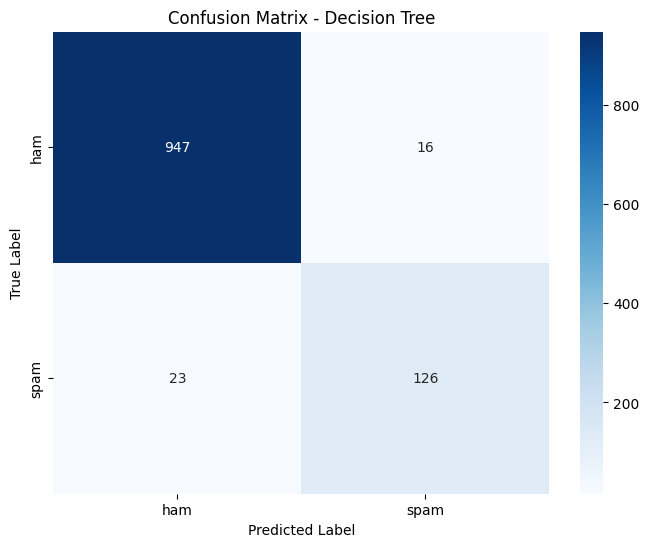

In [ ]:
best_model_dt = grid_search_dt.best_estimator_
test_predictions_dt = best_model_dt.predict(test_tfidf)

report = classification_report(test_df['category'], test_predictions_dt)
print(report)

cm = confusion_matrix(test_df['category'], test_predictions_dt)

# Plot confusion matrix

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Logistic Regression Classifier

The Logistic Regression model was trained using GridSearchCV with the following hyperparameters:

- `penalty`: ['l1', 'l2', 'elasticnet', 'none']
    - Regularization type to prevent overfitting
    - l1: Lasso regularization, promotes sparsity
    - l2: Ridge regularization, handles multicollinearity
    - elasticnet: Combination of l1 and l2
    - none: No regularization

- `C`: [0.01, 0.1, 1, 10, 20]
    - Inverse of regularization strength
    - Smaller values: Stronger regularization
    - Larger values: Less regularization

- `solver`: ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    - different algorithms for optimization

In [ ]:
lr_model = LogisticRegression(max_iter=1000)

param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 20],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                            scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

grid_search_lr.fit(train_tfidf, train_df['category'])

print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Score for Logistic Regression:", grid_search_lr.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for Logistic Regression: {'C': 20, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score for Logistic Regression: 0.9741272296693266


##### Testing the model on `test set`

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       963
        spam       0.97      0.89      0.93       149

    accuracy                           0.98      1112
   macro avg       0.98      0.94      0.96      1112
weighted avg       0.98      0.98      0.98      1112



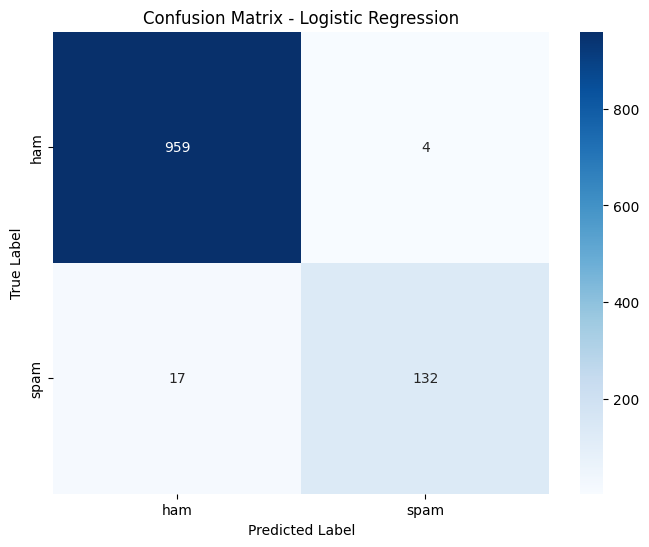

In [ ]:
best_model_lr = grid_search_lr.best_estimator_
test_predictions_lr = best_model_lr.predict(test_tfidf)

report_lr = classification_report(test_df['category'], test_predictions_lr)
print(report_lr)

cm_lr = confusion_matrix(test_df['category'], test_predictions_lr)

# Plot confusion matrix

plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Support Vector Machine (SVM) Classifier

The SVM model was trained using GridSearchCV with the following hyperparameters:

- `C`: [0.1, 1, 10, 100]
    - Regularization parameter
    - Controls trade-off between margin maximization and error minimization
    - Smaller values: Larger margin, more regularization
    - Larger values: Smaller margin, less regularization

- `gamma`: [1, 0.1, 0.01, 0.001]
    - Kernel coefficient for 'rbf', 'poly' and 'sigmoid' kernels
    - Defines influence range of each training example
    - Larger values denote Smaller influence range

- `kernel`: ['linear', 'rbf', 'poly', 'sigmoid']
    - Determines the type of hyperplane used to separate the data
    - linear: Linear separation
    - rbf: Radial Basis Function, handles non-linear classification
    - poly: Polynomial function, can capture more complex patterns
    - sigmoid: Hyperbolic tangent, similar to neural network

In [ ]:
svc_model = SVC()

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search_svc = GridSearchCV(estimator=svc_model, param_grid=param_grid_svc, 
                            scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

grid_search_svc.fit(train_tfidf, train_df['category'])

print("Best Parameters for SVC:", grid_search_svc.best_params_)
print("Best Score for SVC:", grid_search_svc.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters for SVC: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for SVC: 0.9791887105512836


##### Testing the model on `test set`

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       963
        spam       0.99      0.91      0.94       149

    accuracy                           0.99      1112
   macro avg       0.99      0.95      0.97      1112
weighted avg       0.99      0.99      0.99      1112



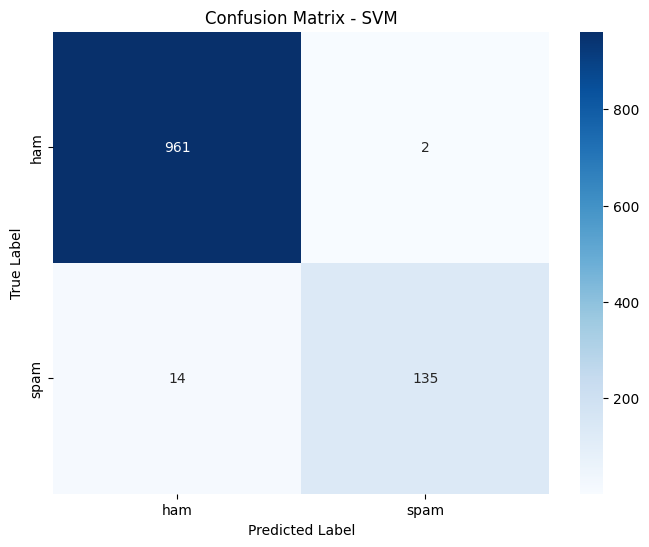

In [ ]:
best_model_svc = grid_search_svc.best_estimator_
test_predictions_svc = best_model_svc.predict(test_tfidf)

report_best = classification_report(test_df['category'], test_predictions_svc)
print(report_best)

cm_svc = confusion_matrix(test_df['category'], test_predictions_svc)

# Plot confusion matrix

plt.figure(figsize=(8,6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Random Forest Classifier

The Random Forest model was trained using GridSearchCV with the following hyperparameters:

- `n_estimators`: [100, 200, 300]
    - Number of trees in the forest
    - More trees generally mean better performance but longer training time
    - Need to balance accuracy vs computational cost

- `criterion`: ['gini', 'entropy']
    - Function to measure quality of split

- `max_depth`: [None, 10, 20, 30] 
    - Maximum depth of each tree
    - None: Nodes expanded until all leaves are pure
    - Lower values help prevent overfitting
    - Controls complexity of individual trees

- `min_samples_split`: [2, 5, 10]
    - Minimum samples required to split internal node
    - Higher values prevent creating too many splits
    - Helps control model complexity and overfitting

- `min_samples_leaf`: [1, 2, 4]
    - Minimum samples required at leaf node
    - Higher values ensure each leaf has enough samples
    - Prevents creating leaves with very few samples
    - Improves generalization performance

- `max_features`: ['auto', 'sqrt', 'log2']
    - I have used `sqrt` only based on the number of features in the dataset. 

In [ ]:
rf_classifier = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, 
                            scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(train_tfidf, train_df['category'])

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Score for Random Forest: 0.9753970089999161


##### Testing the model on `test set`


Random Forest Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       963
        spam       0.99      0.88      0.93       149

    accuracy                           0.98      1112
   macro avg       0.99      0.94      0.96      1112
weighted avg       0.98      0.98      0.98      1112



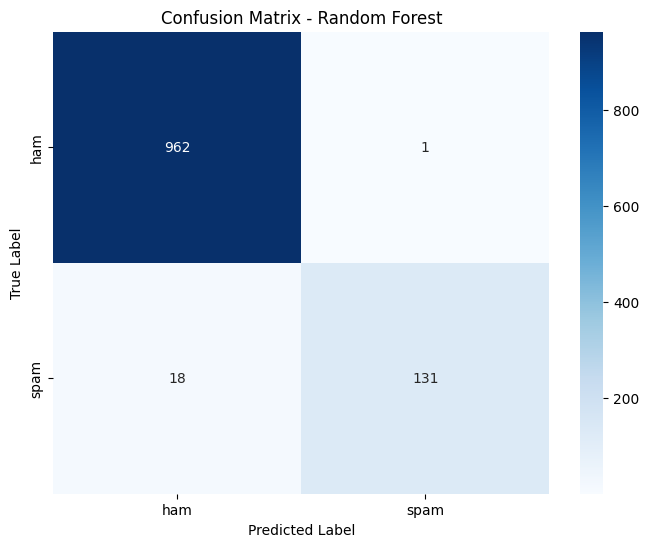

In [ ]:
best_model_rf = grid_search_rf.best_estimator_
test_predictions_rf = best_model_rf.predict(test_tfidf)

print("\nRandom Forest Classification Report:")
print(classification_report(test_df['category'], test_predictions_rf))

cm_rf = confusion_matrix(test_df['category'], test_predictions_rf)

# Plot Random Forest confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


#### Sample Predictions Comparison

This section displays a random sample of 50 test messages and compares predictions across all four models (Decision Tree, Logistic Regression, SVM, Random Forest). For each prediction:
- `✓` indicates correct prediction
- `✗` indicates incorrect prediction

The "All Match" column shows if all models agreed on the correct prediction.

In [ ]:
# Create a stratified random sample of 50 indices
splitter = StratifiedShuffleSplit(n_splits=1, test_size=50, random_state=random.randint(0, 100))
_, sample_indices = next(splitter.split(test_df, test_df['category']))

def convert_to_symbol(pred, actual):
    return '✓' if pred == actual else '✗'

def all_match(row):
    return '✓' if set(row[2:6]) == set('✓') else '✗'

rows = []

for idx in sample_indices:
    message = test_df['processed_message'].iloc[idx]
    # Truncate message to 30 characters
    truncated_message = message[:25] + ('...' if len(message) > 25 else '')
    
    row = [
        truncated_message,
        test_df['category'].iloc[idx],
        convert_to_symbol(test_predictions_dt[idx], test_df['category'].iloc[idx]),
        convert_to_symbol(test_predictions_lr[idx], test_df['category'].iloc[idx]),
        convert_to_symbol(test_predictions_svc[idx], test_df['category'].iloc[idx]),
        convert_to_symbol(test_predictions_rf[idx], test_df['category'].iloc[idx])
    ]

    row.append(all_match(row))
    rows.append(row)

table = PrettyTable()
table.field_names = ["Message", "Actual Label", "Decision Tree", "Logistic Regression", "SVM", "Random Forest", "All Match"]

for row in rows:
    table.add_row(row)

print(table)

+------------------------------+--------------+---------------+---------------------+-----+---------------+-----------+
|           Message            | Actual Label | Decision Tree | Logistic Regression | SVM | Random Forest | All Match |
+------------------------------+--------------+---------------+---------------------+-----+---------------+-----------+
| hello love went day alrig... |     ham      |       ✓       |          ✓          |  ✓  |       ✓       |     ✓     |
| congratulations week comp... |     spam     |       ✓       |          ✓          |  ✓  |       ✓       |     ✓     |
| nothing meant money enter... |     ham      |       ✗       |          ✓          |  ✓  |       ✓       |     ✗     |
| mum say wan go go shun bi... |     ham      |       ✓       |          ✓          |  ✓  |       ✓       |     ✓     |
|       oooh got plenty        |     ham      |       ✓       |          ✓          |  ✓  |       ✓       |     ✓     |
| hm good morning headache ... |     ham

## Model Performance Comparison

| Model | Accuracy | Weighted F1-Score | Ham Precision | Ham Recall | Spam Precision | Spam Recall |
|-------|----------|------------------|---------------|------------|----------------|-------------|
| Decision Tree | 96% | 0.965 | 0.98 | 0.98 | 0.89 | 0.85 |
| Logistic Regression | 98% | 0.98 | 0.98 | 1 | 0.97 | 0.89 |
| SVM | 99% | 0.99 | 0.99 | 1 | 0.99 | 0.91 |
| Random Forest | 98% | 0.98 | 0.98 | 1 | 0.99 | 0.88 |

- All models show strong performance with accuracy and F1-scores between 96-99%.
- The Logistic Regression, SVM and Random Forest models performed marginally better than the Decision Tree classifier.
- For spam detection specifically, the models show high precision (89-92%) and good recall (85-87%) on spam messages.
- They also maintained excellent performance on ham messages with both precision and recall around 98-99%.

##### But, if I have to choose one, I think the `Support Vector Machine` will be the best choice as it outperforms others for all the metrics.
